In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import IPython.display as ipd
import matplotlib.pyplot as plt
import ppgs
import torch
import torchaudio

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
checkpoint = promonet.RUNS_DIR / 'sppg-percentile-085' / 'generator-00400000.pt'

# Local checkpoint to use
# If None, Huggingface will be used unless a checkpoint is given in the CLI
ppgs.LOCAL_CHECKPOINT = f'/repos/ppgs/runs/w2v2fb/00200000.pt'

In [128]:
stems = promonet.load.partition('vctk')['test']
stem = random.choice(stems)
speakers = list(set(stem.split('/')[0] for stem in stems))
averages = promonet.load.per_speaker_averages()
speaker = stem.split('/')[0]
text = promonet.load.text(promonet.CACHE_DIR / 'vctk' / f'{stem}.txt')
audio = promonet.load.audio(promonet.CACHE_DIR / 'vctk' / f'{stem}-100.wav')
print(text)
ipd.Audio(audio, rate=promonet.SAMPLE_RATE)

Many of these properties are located in the south of England.



### ProMoNet editing pipeline

In [89]:
def edit(
    condition,
    audio,
    speaker,
    target_speaker=None,
    edit_kwargs=None,
    synthesize_kwargs=None
):
    """Edit speech and plot the results"""
    if edit_kwargs is None:
        edit_kwargs = {}
    if synthesize_kwargs  is None:
        synthesize_kwargs = {}

    # Preprocess
    loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
        audio,
        features=['ppg', 'pitch', 'periodicity', 'loudness'],
        gpu=0)

    # Edit
    (
        edited_pitch,
        edited_periodicity,
        edited_loudness,
        edited_ppg
    )= promonet.edit.from_features(
        pitch,
        periodicity,
        loudness,
        ppg,
        **edit_kwargs)

    # Synthesize
    edited = promonet.synthesize.from_features(
        edited_pitch,
        edited_periodicity,
        edited_loudness,
        edited_ppg,
        speaker=int(speaker),
        checkpoint=checkpoint,
        gpu=0,
        **synthesize_kwargs)
    
    # Plot and save results
    plot(
        condition,
        audio,
        edited,
        edited_pitch,
        edited_periodicity,
        edited_loudness,
        edited_ppg)


def plot(
    condition,
    audio,
    edited,
    edited_pitch,
    edited_periodicity,
    edited_loudness,
    edited_ppg
):
    """Plot overlay of features from input and synthesized audio"""
    # Preprocess synthesized audio
    (
        predicted_loudness, 
        predicted_pitch,
        predicted_periodicity,
        predicted_ppg
    )= promonet.preprocess.from_audio(
        edited,
        features=['ppg', 'pitch', 'periodicity', 'loudness'],
        gpu=0)

    # Make audio player
    ipd.display(ipd.Audio(edited.cpu(), rate=promonet.SAMPLE_RATE))

    # Make plot
    figure = promonet.plot.from_features(
        audio,
        edited_pitch,
        edited_periodicity,
        promonet.loudness.band_average(edited_loudness, 1),
        edited_ppg,
        predicted_pitch,
        predicted_periodicity,
        promonet.loudness.band_average(predicted_loudness, 1),
        predicted_ppg,
        features=['ppg', 'pitch', 'periodicity', 'loudness'])

    # Save
    figure.savefig(
        f'{condition}.png',
        bbox_inches='tight',
        pad_inches=0,
        transparent=True)
    torchaudio.save(f'{condition}-original.wav', audio.cpu(), promonet.SAMPLE_RATE)
    torchaudio.save(f'{condition}.wav', edited.cpu(), promonet.SAMPLE_RATE)

### Original

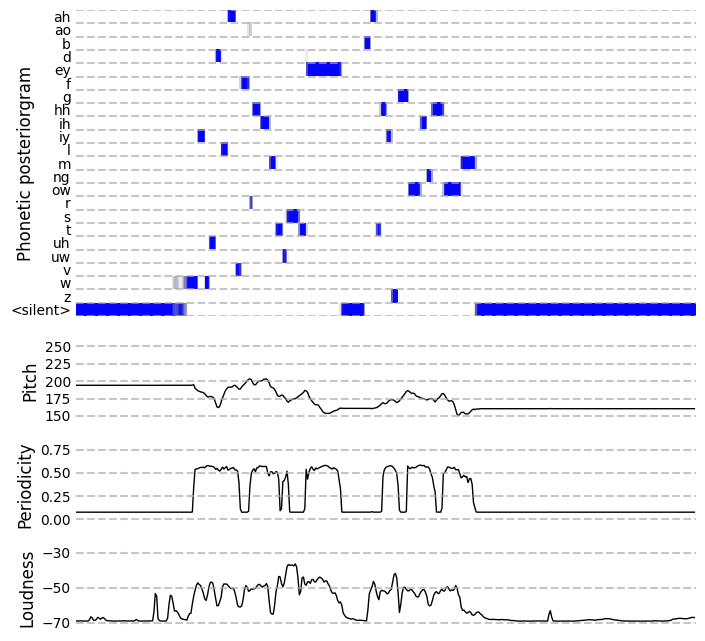

In [90]:
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
figure = promonet.plot.from_features(
    audio,
    pitch,
    periodicity,
    promonet.loudness.band_average(loudness, 1),
    ppg,
    features=['ppg', 'pitch', 'periodicity', 'loudness'])
figure.savefig(f'original.png', bbox_inches='tight', pad_inches=0, transparent=True)

### Reconstruction

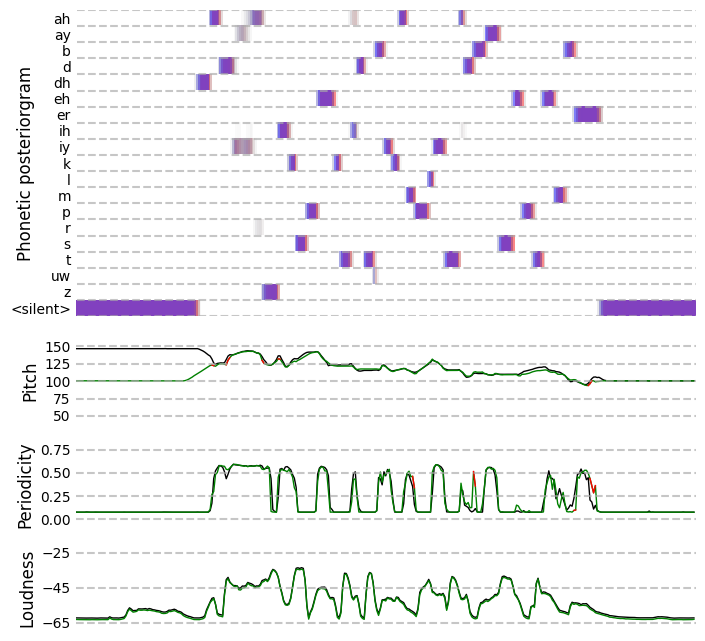

In [58]:
file = (
    promonet.EVAL_DIR /
    'subjective' /
    'mels-ours' /
    f'vctk-{stem.replace("/", "-")}-original-100.wav')
mel_audio = promonet.load.audio(file)
loudness, pitch, periodicity, ppg = promonet.preprocess.from_audio(
    audio,
    features=['ppg', 'pitch', 'periodicity', 'loudness'],
    gpu=0)
plot(
    'mel-reconstruction',
    audio,
    mel_audio,
    pitch,
    periodicity,
    loudness,
    ppg)

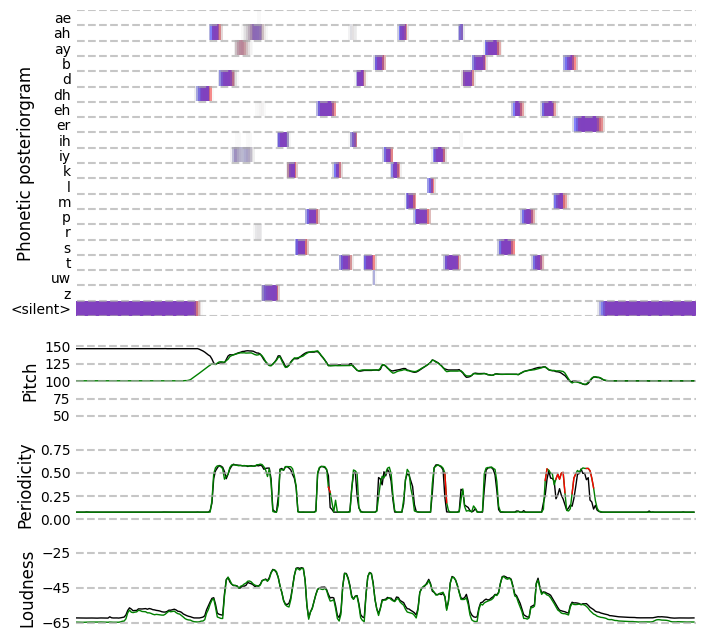

In [59]:
edit('reconstruction', audio, speaker)

### Pitch shifting

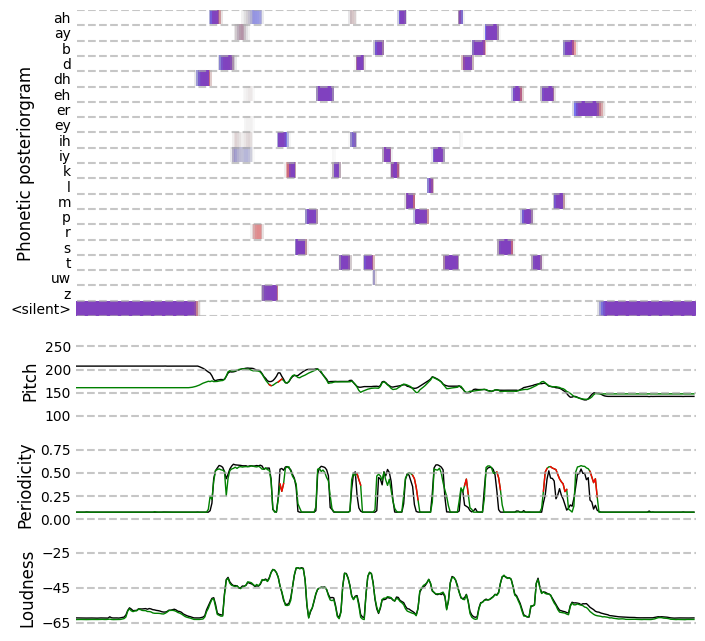

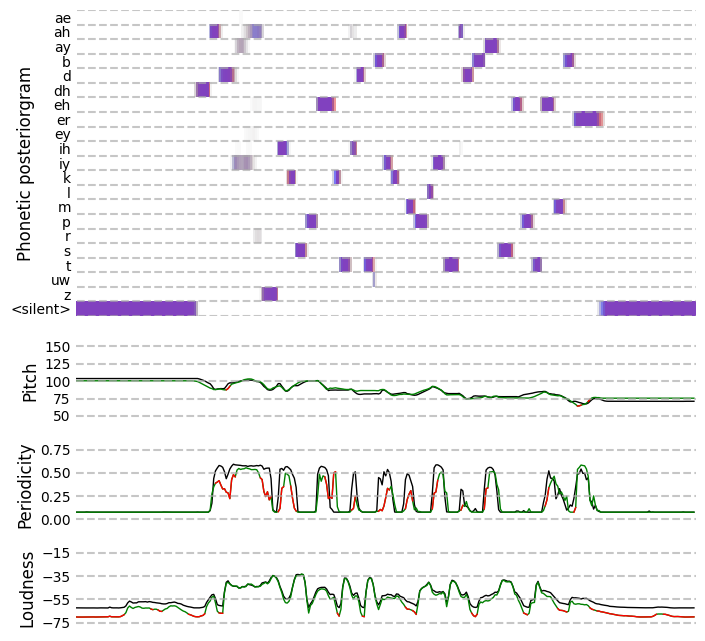

In [61]:
edit('shifted-141', audio, speaker, edit_kwargs={'pitch_shift_cents': 600.})
edit('shifted-071', audio, speaker, edit_kwargs={'pitch_shift_cents': -600.})

### Time-stretching

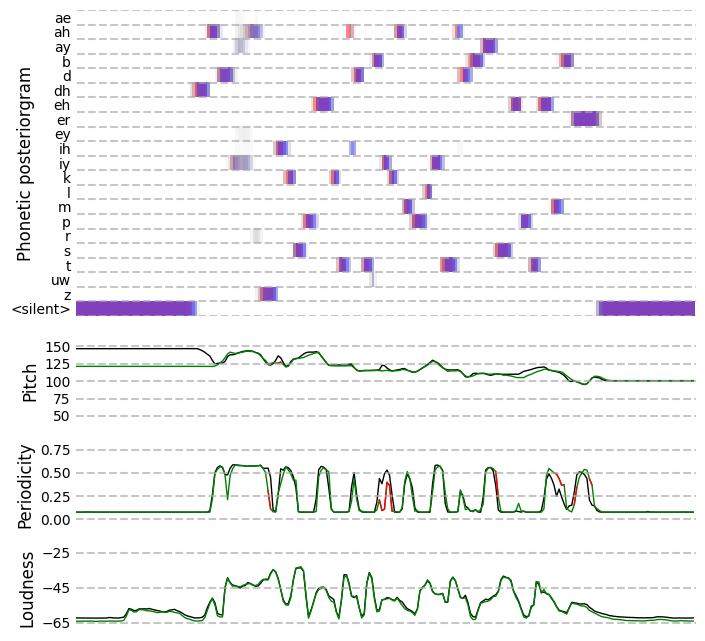

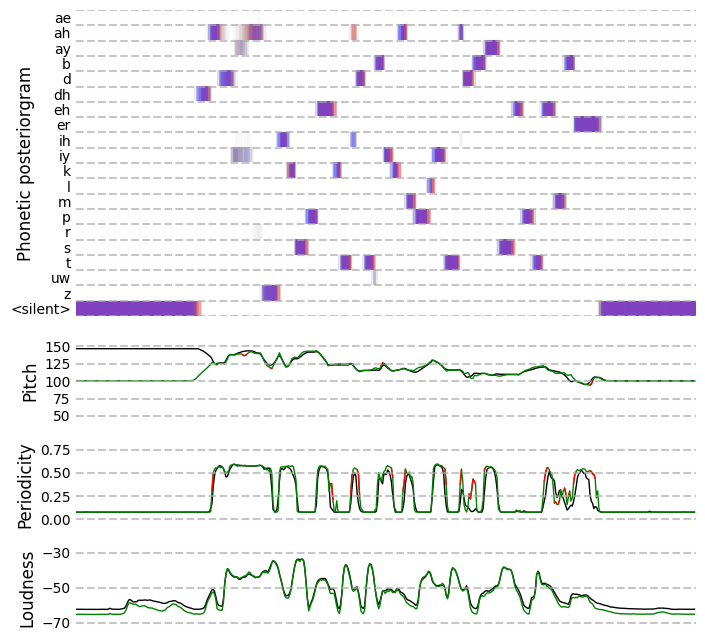

In [62]:
edit('stretched-141', audio, speaker, edit_kwargs={'time_stretch_ratio': 1.41})
edit('stretched-071', audio, speaker, edit_kwargs={'time_stretch_ratio': 0.71})

### Volume adjust

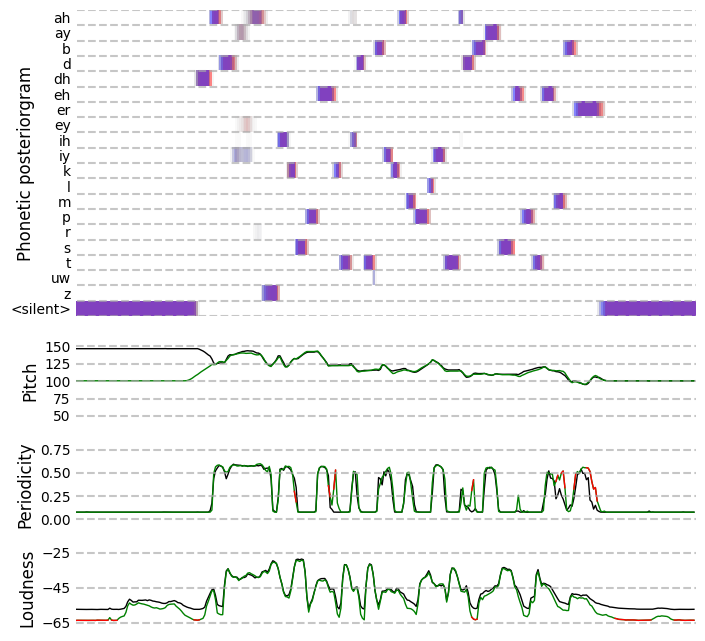

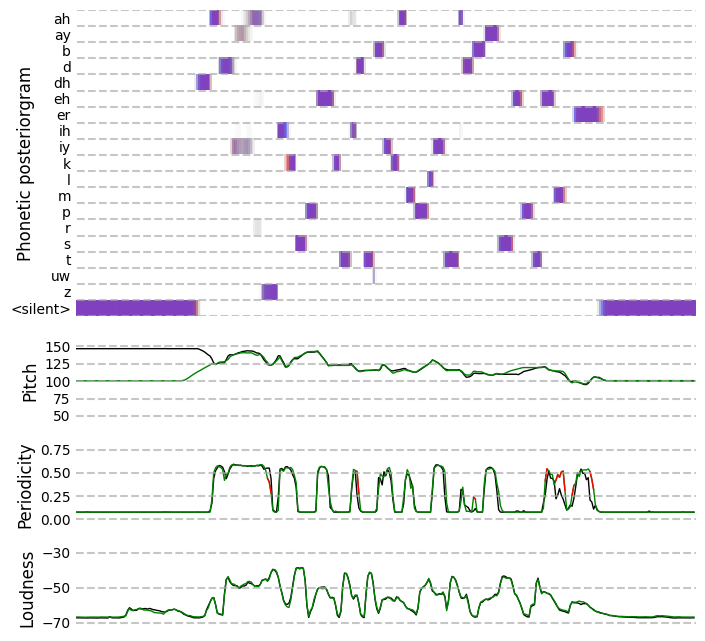

In [63]:
edit('volume-141', audio, speaker, edit_kwargs={'loudness_scale_db': promonet.convert.ratio_to_db(1.41)})
edit('volume-071', audio, speaker, edit_kwargs={'loudness_scale_db': promonet.convert.ratio_to_db(0.71)})

### Voice conversion

In [118]:
# Select a random target speaker
target_speaker = speaker
while target_speaker == speaker:
    target_speaker = random.choice(speakers)
mean_difference_cents = promonet.convert.ratio_to_cents(averages[target_speaker] / averages[speaker])
print(averages[speaker], averages[target_speaker], mean_difference_cents)
target_sample_stem = random.choice(
    [stem for stem in stems if stem.startswith(target_speaker)])
target_sample = promonet.load.audio(
    promonet.CACHE_DIR /
    'vctk' /
    f'{target_sample_stem}-100.wav')
ipd.display(ipd.Audio(target_sample.cpu(), rate=promonet.SAMPLE_RATE))
torchaudio.save(f'voice-conversion-target.wav', target_sample.cpu(), promonet.SAMPLE_RATE)

184.25529723803535 99.11680231904514 -1073.4054565429685


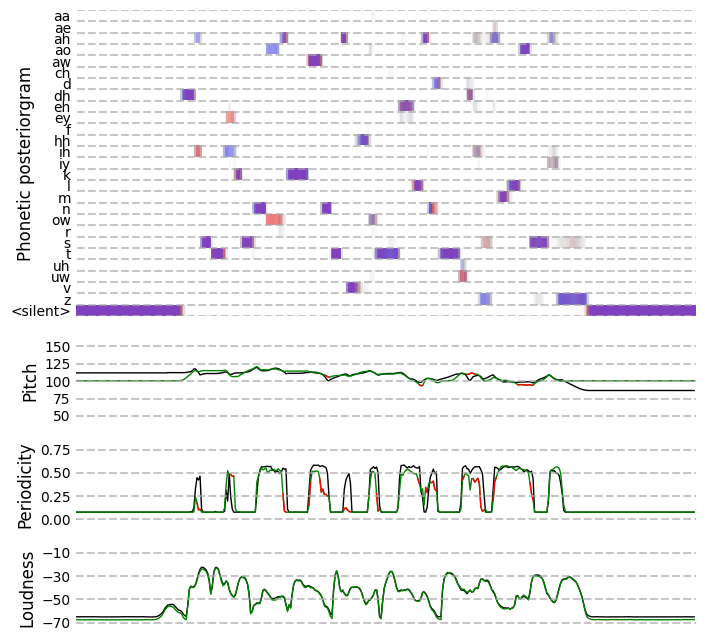

In [119]:
# Edit speaker
edit(
    'voice-conversion',
    audio,
    target_speaker,
    edit_kwargs={'pitch_shift_cents': mean_difference_cents})

### Formant editing

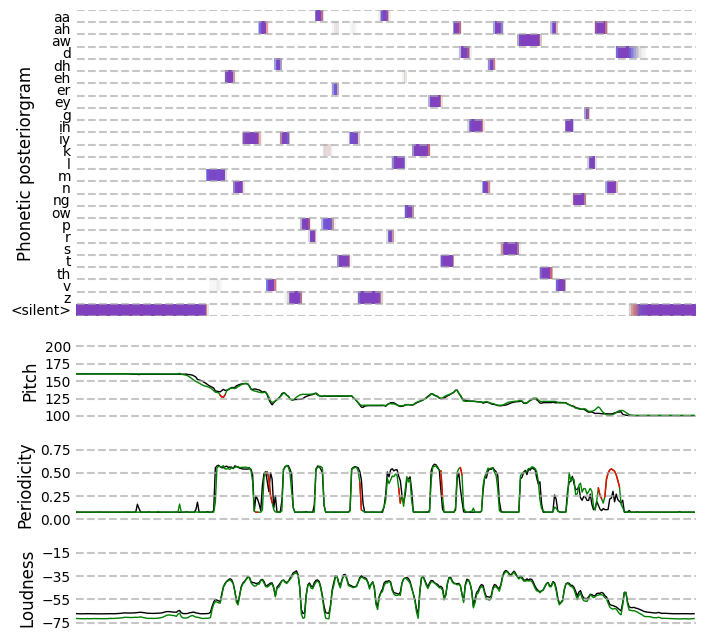

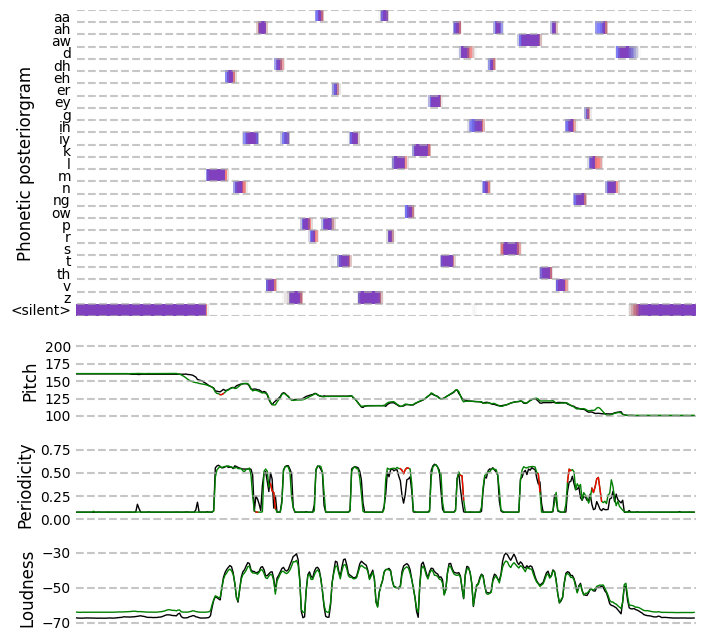

In [131]:
edit('formant-141', audio, speaker, synthesize_kwargs={'formant_ratio': 1.41})
edit('formant-071', audio, speaker, synthesize_kwargs={'formant_ratio': 0.71})

### Loudness editing

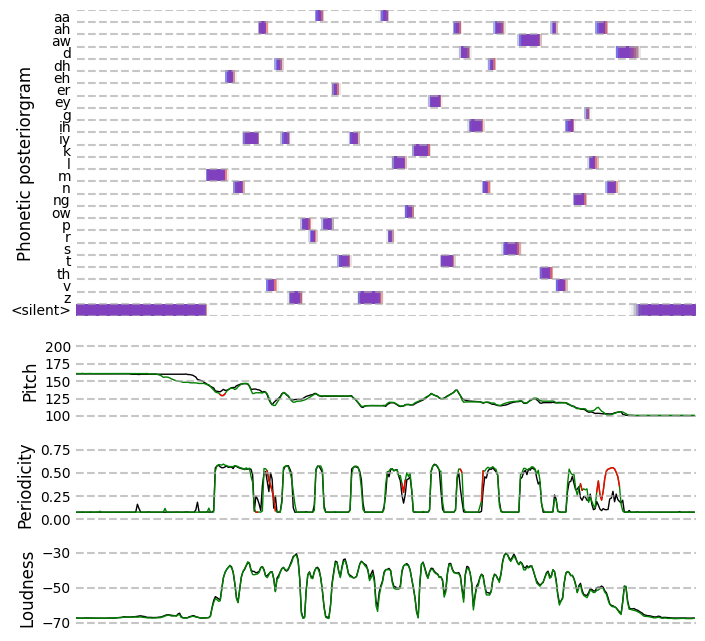

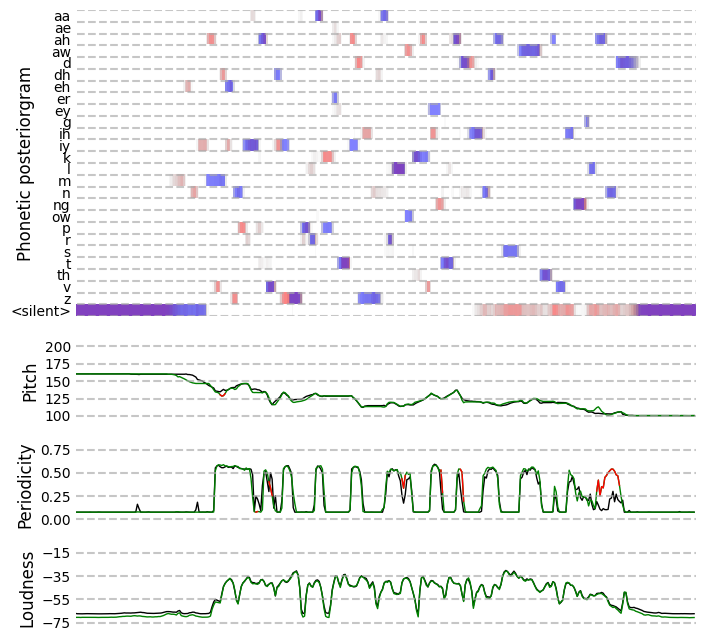

In [132]:
edit('loudness-141', audio, speaker, synthesize_kwargs={'loudness_ratio': 1.41})
edit('loudness-071', audio, speaker, synthesize_kwargs={'loudness_ratio': 0.71})